In [7]:
import numpy as np
from implementations_leo import *
from proj1_helpers import *
from Package_build import standardize, learning_by_gradient_descent, logistic_reg_GD
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [9]:
#Load the data both from train and test csv file
y, x, ids = load_csv_data("train.csv", sub_sample=False)
_, x_submission, ids_submission = load_csv_data("test.csv", sub_sample=False)



In [3]:
bad_sub_arrays = np.where(x == -999.)[0] #find lines of the matrix x where we have at least 
print('With repeated lines because -999 appears more than once in some lines',bad_sub_arrays[:50]) # just the beginning
print('\ntruncated output', y[:20])
bad_sub_arrays = np.unique(bad_sub_arrays)
print('The list of lines with insignificant data, with no repetitions')
bad_sub_arrays[:50]

With repeated lines because -999 appears more than once in some lines [1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 7 7
 7 7 7 7 7 8 8 8 8 8 8 8 8]

truncated output [ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
 -1. -1.]
The list of lines with insignificant data, with no repetitions


array([ 1,  2,  3,  4,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 24, 25, 26, 28, 30, 34, 35, 36, 37, 40, 41, 43, 44, 47, 48,
       49, 50, 52, 53, 54, 55, 56, 58, 61, 62, 63, 64, 65, 66, 67, 69], dtype=int64)

In [4]:
xclean = np.delete(x, bad_sub_arrays, axis = 0)
print('There are no -999 anymore',np.where(xclean == -999.)) #it works!

xclean = standardize(xclean)
print('\n Here is a bit of the clean x\n', xclean[0:10]) #works

yclean = np.delete(y, bad_sub_arrays, axis = 0)
print('\nHere is a bit of the clean y', yclean[:10]) #appears to work. Compare with y above

There are no -999 anymore (array([], dtype=int64), array([], dtype=int64))

 Here is a bit of the clean x
 [[ 0.25767126  0.53283515  0.47461094 -1.09345441 -0.87064819 -0.63242833
   0.98731346  1.37804494  0.51549536 -0.64313461  0.09205652  0.8203249
  -0.6621994  -0.44063129  0.86513362  0.20892619 -0.02803712  1.90142579
  -1.352776   -0.89329993 -0.15656359 -0.54298155 -0.6604439  -0.57866597
   1.23439906  0.25179525 -0.36784371  0.61296467 -1.35932881 -0.64515168]
 [-0.54438812 -0.70635039 -0.47504382  0.06438322  0.11525063 -0.233525
   0.09492308 -0.81913195  1.21210996 -0.02033658 -0.81324448 -0.17116673
   1.28298905  0.26731433  0.31741279  0.73028451 -0.72463203 -0.73523156
   0.99980927 -0.33319688  1.22941639 -0.3705594   1.51413316 -0.23960808
  -1.37778781 -0.35452909 -0.05432042  0.11591226  1.71182322  0.09496062]
 [ 0.4269521  -0.20839975  0.71903446 -0.0694513  -0.97175138 -0.54847232
   0.27668569  1.21925954 -0.87776921  0.18766458  1.72141616  0.8170812
   0.82

(20434, 361)
Correct answers:  82.436135852 % for lambda = 0.000010


C:\Users\leope\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1e-05, right=1e-05
  'left=%s, right=%s') % (left, right))


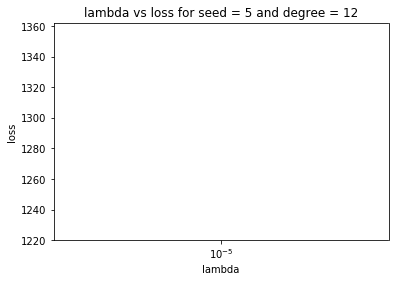

In [8]:
'''Define values to perform Ridge regression with simple splitting of the dataset'''

degree = 12
ratio = 0.7 #train/test examples
lambdas = [1e-5]
seed = 5

ridge_with_simple_splitting(yclean,xclean, degree, ratio, lambdas, seed)

In [ ]:
tx = np.c_[np.ones(np.size(xclean[:,0])), xclean]
#w = least_squares(yclean[:10], tx.T[0:10])
#logistic_reg_GD(yclean, tx, w)

In [5]:
def ridge_with_simple_splitting(y,x, degree, ratio, lambdas, seed = 1):
    loss = []
    y_train, x_train, y_test, x_test = split_data(y, x, ratio, seed)

    phi_test = build_poly(x_test, degree)
    phi_train = build_poly(x_train, degree)
    print(phi_test.shape)

    for lambda_ in lambdas:

        w = ridge_regression(y_train, phi_train, lambda_)
        rmse_test = cost_function(y_test, phi_test, w)

        loss.append(rmse_test)

        print("Correct answers: ",predict(y_test,phi_test,w), '%', "for lambda = %f" %lambda_)
    semilog_loss_lambda_plot(loss, lambdas, seed, degree)

In [ ]:
def cross_validation_ridge(y, x, k_fold, degree, lambdas, seed = 1):
    '''perform cross validation on ridge regression
    lambdas: array, better if log spaced
    print percentage of correct answers for each k, lambda
    plot in semilog scale rmse as function of lambda'''
    
    #create empty
    loss = np.zeros((len(lambdas))) 
    #add poly values to the features
    phi = build_poly(x, degree, False)
    #build indices for cross validation
    k_indices = build_k_indices(y, k_fold, seed)

    for k in range(k_fold):
        #split data according to kth fold
        y_train, phi_train, y_test, phi_test = split_data_cross(y, phi, k, k_indices, degree)

        loss_temp = [] #empty list to store losses for a given k
        
        for lambda_ in lambdas:
            w = ridge_regression(y_train, phi_train, lambda_)
            
            rmse_test = cost_function(y_test, phi_test, w)/k_fold #divide by k_fold in order to mean over them
            loss_temp.append(rmse_test)

            print("Correct answers: ",predict(y_test,phi_test,w), '%', "for k = %i, lambda = %f" %(k, lambda_))
        loss += loss_temp
    semilog_loss_lambda_plot(loss, lambdas, seed, degree)

In [ ]:
k_fold = 4
degree = 12
lambdas = np.logspace(-8,3,100) #good lambda = 20
seed = 6

cross_validation_ridge(yclean, xclean, k_fold, degree, lambdas, seed)

In [ ]:
def create_submission(x_submission, degree, ids_submission):
    phi_submission = build_poly(x_submission, degree, False) 

    y_predicted = np.sign(phi_submission.dot(w))
    create_csv_submission(ids_submission, y_predicted, "predictions_6.csv")